In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/cdc_project/train_preprocessed.csv")

df_train["price_bin"] = pd.qcut(
    df_train["price"], q =5, labels = ["vlow", "low", "medium","high", "vhigh"]
)

In [5]:
sample_ids = (df_train.groupby("price_bin")
                .sample(1, random_state = 42)["id"]
                .astype(str)
                 .tolist()
)
sample_ids

/tmp/ipython-input-2630813163.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_ids = (df_train.groupby("price_bin")


['1822059331', '4142450510', '5101405338', '3902300100', '2600010330']

In [6]:
FEATURE_COLS = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'waterfront', 'view', 'condition', 'grade', 'sqft_above',
    'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
    'sqft_living15', 'sqft_lot15', 'sqft_per_bed', 'bath_per_bed',
    'lot_living_ratio', 'basements_ratio', 'above_floors_ratio',
    'living_density', 'lot_density', 'year_sale', 'month_sale',
    'quarter_sale', 'days_since_start', 'renovation',
    'years_since_renovation'
]



In [14]:
IMAGE_DIR = "/content/train"

In [8]:
img_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

In [9]:
class MultiModalRegressor(nn.Module):

  def __init__(self, tab_dim):
    super().__init__()

    self.cnn = models.resnet18(pretrained = True)
    self.cnn.fc = nn.Identity()

    for p in self.cnn.parameters():
      p.requires_grad = False


    self.mlp = nn.Sequential(
        nn.Linear(tab_dim, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.3)
    )

    self.regressor = nn.Sequential(
        nn.Linear(128 + 512, 128),
        nn.ReLU(),
        nn.Linear(128,1)
    )
  def forward(self, image, tabular):
    img_feat = self.cnn(image)
    tab_feat = self.mlp(tabular)

    x = torch.cat([img_feat, tab_feat], dim = 1)

    return self.regressor(x).squeeze(1)

In [10]:
model = MultiModalRegressor(tab_dim = len(FEATURE_COLS)).to(device)
state_dict = torch.load("/content/drive/MyDrive/cdc_project/models_current/multimodal_model.pth", map_location = device)
model.load_state_dict(state_dict)

model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 98.3MB/s]


MultiModalRegressor(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [18]:
for p in model.cnn.parameters():
  p.requires_grad = True

In [11]:
class GRAD_CAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self):
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam


In [20]:
def run_gradcam(example_id, image_dir):
    model.eval()

    # Load image
    img_path = os.path.join(image_dir, f"{example_id}.png")
    image = Image.open(img_path).convert("RGB")
    img_tensor = img_tfms(image).unsqueeze(0).to(device)

    # Load tabular features
    tab = torch.tensor(
        df_train.loc[df_train["id"].astype(str) == example_id, FEATURE_COLS].values,
        dtype=torch.float32
    ).to(device)

    # Initialize Grad-CAM
    cam_extractor = GRAD_CAM(model, model.cnn.layer4[-1])

    # Forward + backward
    output = model(img_tensor, tab)
    model.zero_grad()
    score = output.squeeze()
    score.backward()

    # Generate CAM
    cam = cam_extractor.generate()[0].detach().cpu().numpy()

    # Visualization
    heatmap = cv2.resize(cam, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original = np.array(image.resize((224, 224)))
    overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM | House ID: {example_id}")
    plt.show()


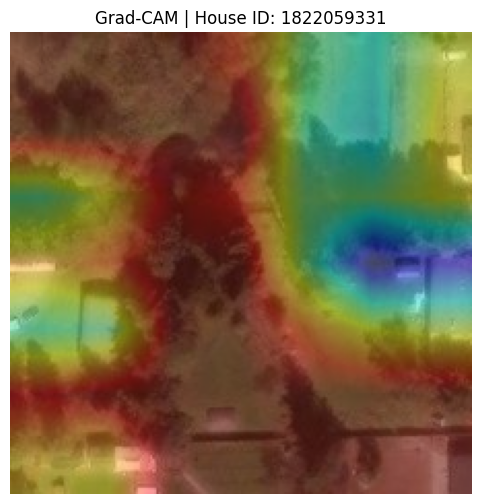

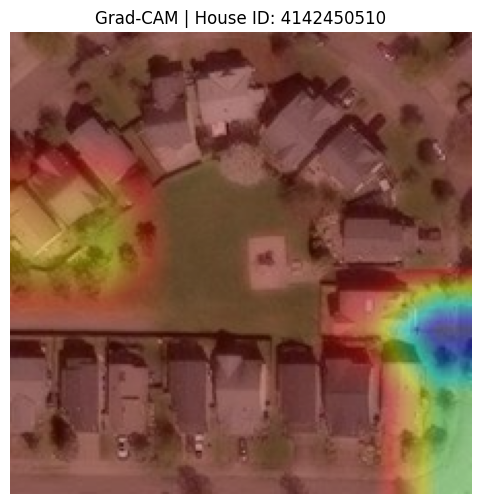

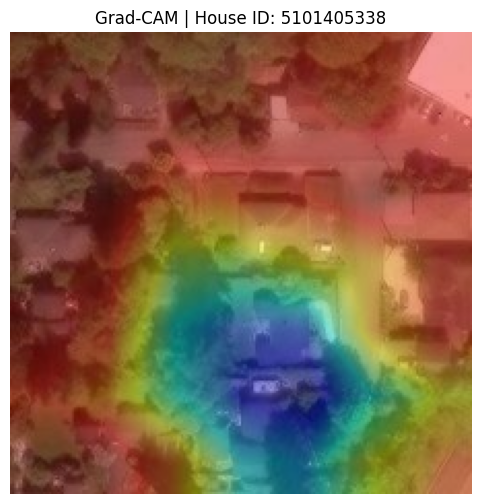

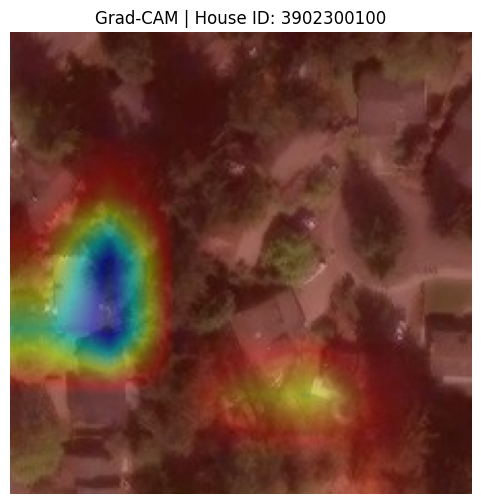

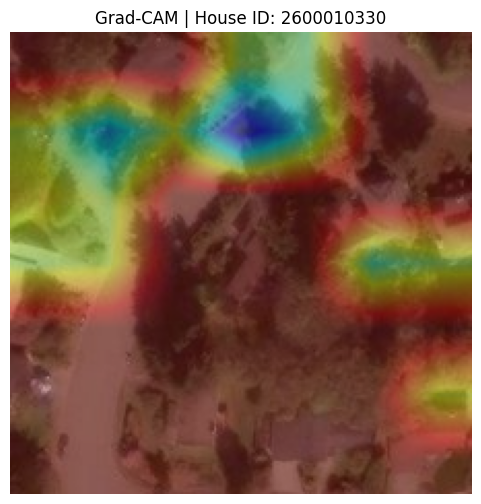

In [21]:
for example_id in sample_ids:
  run_gradcam(example_id, IMAGE_DIR)
